# PAKDD 2009 Data Mining Competition

In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# params
seed = 42

## 1. Подгрузка данных

Качать нужно [отсюда](https://github.com/JLZml/Credit-Scoring-Data-Sets/tree/master/2.%20PAKDD%202009%20Data%20Mining%20Competition), внутри архива берем `PAKDD-2010 training data.zip`. 

Показатели из других работ:

| Paper | ACC | AUC | Gini |
| --- | --- | --- | --- | 
| Engelmann & Lessmann, 2021 | - | 0.6203 | 0.2406| 
| Tsai et al., 2021 | - | 0.837 | 0.6740 |

Также нужно распаковать файл `PAKDD2010_VariablesList.XLS`, отсюда возьмем названия столбцов.

In [3]:
var_info = pd.read_excel('PAKDD2010_VariablesList.XLS', index_col=0)
df = pd.read_csv('PAKDD2010_Modeling_Data copy.txt', sep='\t', low_memory=False, header=None, names=var_info['Var_Title'])

## 2. Анализ факторов

### Список факторов

`D_type` - Numeric, Categorical, Trash

 | Var_Id | Var_Title | Var_Description | Field_Content | D_type | Comment | 
 | --- | --- | --- | --- | --- | --- | 
 | 1 | ID_CLIENT | Sequential number for the applicant (to be used as a key) | 1-50000, 50001-70000, 70001-90000 | T |  | 
 | 2 | CLERK_TYPE | Not informed | C | T |  | 
 | 3 | PAYMENT_DAY | Day of the month for bill payment, chosen by the applicant | 1,5,10,15,20,25 | C |  | 
 | 4 | APPLICATION_SUBMISSION_TYPE | Indicates if the application was submitted via the internet or in person/posted | Web, Carga | C |  | 
 | 5 | QUANT_ADDITIONAL_CARDS | Quantity of additional cards asked for in the same application form | 1,2,NULL | T | единственное значение | 
 | 6 | POSTAL_ADDRESS_TYPE | Indicates if the address for posting is the home address or other. Encoding not informed. | 1.2 | C |  | 
 | 7 | SEX |  | M=Male, F=Female | C | F, M, N, 0 | 
 | 8 | MARITAL_STATUS | Encoding not informed | 1,2,3,4,5,6,7 | C | 8 уникальных значений | 
 | 9 | QUANT_DEPENDANTS |  | 0, 1, 2, ... | N | Проставил на основе значений | 
 | 10 | EDUCATION_LEVEL_1 | Edducational level in gradual order not informed | 1,2,3,4,5 | T | единственное значение | 
 | 11 | STATE_OF_BIRTH |  | Brazilian states, XX, missing | C |  | 
 | 12 | CITY_OF_BIRTH |  |  | T | Дофига строк | 
 | 13 | NACIONALITY | Country of birth. Encoding not informed but Brazil is likely to be equal 1. | 0, 1, 2 | C |  | 
 | 14 | RESIDENCIAL_STATE | State of residence |  | C |  | 
 | 15 | RESIDENCIAL_CITY | City of residence |  | T | Дофига строк | 
 | 16 | RESIDENCIAL_BOROUGH | Borough of residence |  | T | Дофига строк | 
 | 17 | FLAG_RESIDENCIAL_PHONE | Indicates if the applicant possesses a home phone | Y,N | C |  | 
 | 18 | RESIDENCIAL_PHONE_AREA_CODE | Three-digit pseudo-code |  | С | Кат, несмотря на числа | 
 | 19 | RESIDENCE_TYPE | Encoding not informed. In general, there are the types: owned, mortgage, rented, parents, family etc. | 1,2,3,4,5,NULL | C | Кат, несмотря на числа | 
 | 20 | MONTHS_IN_RESIDENCE | Time in the current residence in months | 1,2,... , NULL | N |  | 
 | 21 | FLAG_MOBILE_PHONE | Indicates if the applicant possesses a mobile phone | Y,N | T | единственное значение | 
 | 22 | FLAG_EMAIL | Indicates if the applicant possesses an e-mail address | 0.1 | C |  | 
 | 23 | PERSONAL_MONTHLY_INCOME | Applicant's personal regular monthly income in Brazilian currency (R$) |  | N |  | 
 | 24 | OTHER_INCOMES | Applicant's other incomes monthly averaged in Brazilian currency (R$) |  | N |  | 
 | 25 | FLAG_VISA | Flag indicating if the applicant is a VISA credit card holder | 0.1 | C |  | 
 | 26 | FLAG_MASTERCARD | Flag indicating if the applicant is a MASTERCARD credit card holder | 0.1 | C |  | 
 | 27 | FLAG_DINERS | Flag indicating if the applicant is a SINERS credit card holder | 0.1 | C |  | 
 | 28 | FLAG_AMERICAN_EXPRESS | Flag indicating if the applicant is an AMERICAN EXPRESS credit card holder | 0.1 | C |  | 
 | 29 | FLAG_OTHER_CARDS | Despite being label "FLAG", this field presents three values not explained | 0,1,NULL | C | нуллов в трейне нет | 
 | 30 | QUANT_BANKING_ACCOUNTS |  | 0,1,2 | N | мб стоит указать как кат | 
 | 31 | QUANT_SPECIAL_BANKING_ACCOUNTS |  | 0,1,2 | N | мб стоит указать как кат | 
 | 32 | PERSONAL_ASSETS_VALUE | Total value of the personal possessions such as houses, cars etc. in Brazilian currency (R$). |  | N |  | 
 | 33 | QUANT_CARS | Quantity of cars the applicant possesses |  | N |  | 
 | 34 | COMPANY | If the applicant has supplied the name of the company where he/she formally works | Y,N | C |  | 
 | 35 | PROFESSIONAL_STATE | State where the applicant works |  | C |  | 
 | 36 | PROFESSIONAL_CITY | City where the applicant works |  | T | Дофига строк | 
 | 37 | PROFESSIONAL_BOROUGH | Borough where the applicant works |  | T | Дофига строк | 
 | 38 | FLAG_PROFESSIONAL_PHONE | Indicates if the professional phone number was supplied | Y,N | С |  | 
 | 39 | PROFESSIONAL_PHONE_AREA_CODE | Three-digit pseudo-code |  | C | Кат, несмотря на числа | 
 | 40 | MONTHS_IN_THE_JOB | Time in the current job in months |  | N |  | 
 | 41 | PROFESSION_CODE | Applicant's profession code. Encoding not informed | 1,2,3,... | C | Кат, несмотря на числа | 
 | 42 | OCCUPATION_TYPE | Encoding not informed | 1,2,3,4,5,NULL | C |  | 
 | 43 | MATE_PROFESSION_CODE | Mate's profession code. Encoding not informed | 1,2,3,... | C |  | 
 | 44 | EDUCATION_LEVEL | Mate's educational level in gradual order not informed | 1,2,3,4,5 | N | Можно и кат | 
 | 45 | FLAG_HOME_ADDRESS_DOCUMENT | Flag indicating documental confirmation of home address | 0.1 | T | единственное значение | 
 | 46 | FLAG_RG | Flag indicating documental confirmation of citizen card number | 0.1 | T | единственное значение | 
 | 47 | FLAG_CPF | Flag indicating documental confirmation of tax payer status | 0.1 | T | единственное значение | 
 | 48 | FLAG_INCOME_PROOF | Flag indicating documental confirmation of income | 0.1 | T | единственное значение | 
 | 49 | PRODUCT | Type of credit product applied. Encoding not informed | 1,2,7 | C |  | 
 | 50 | FLAG_ACSP_RECORD | Flag indicating if the applicant has any previous credit delinquency | Y, N | T | единственное значение | 
 | 51 | AGE | Applicant's age at the moment of submission |  | N |  | 
 | 52 | RESIDENCIAL_ZIP_3 | Three most significant digits of the actual home zip code |  | T | единственное значение | 
 | 53 | PROFESSIONAL_ZIP_3 | Three most significant digits of the actual job zip code |  | T | единственное значение | 
 | 54 | TARGET_LABEL_BAD=1 | Target Variable: BAD=1, GOOD=0 |  |  |  | 




In [4]:
# распределение по типам столбцов, T - trash
var_info.groupby('D_type')['D_type'].count()

D_type
C    17
N     8
T    28
Name: D_type, dtype: int64

In [5]:
# заполняем пропуски в соответствии со словарем ниже
missing = {
    'APPLICATION_SUBMISSION_TYPE' : '0',
    'STATE_OF_BIRTH' : ' ',
    'RESIDENCIAL_PHONE_AREA_CODE' : ' ',
    'PROFESSIONAL_STATE' : ' ',
    'PROFESSIONAL_PHONE_AREA_CODE' : ' '
}

for col, val in missing.items():
    df.loc[df[col] == val, col] = np.nan

In [6]:
satisfactory_features = var_info.loc[
    var_info['D_type'].isin(['C', 'N']),
    'Var_Title'
    ]

X = df.loc[:, satisfactory_features]
y = df['TARGET_LABEL_BAD=1'].rename("target")

In [7]:
var_info.loc[var_info['D_type'] == 'N', 'Var_Title'].to_list()

['PAYMENT_DAY',
 'QUANT_DEPENDANTS',
 'MONTHS_IN_RESIDENCE',
 'PERSONAL_MONTHLY_INCOME',
 'QUANT_BANKING_ACCOUNTS',
 'QUANT_CARS',
 'EDUCATION_LEVEL',
 'AGE']

In [8]:
# PAYMENT_DAY: OK
X["QUANT_DEPENDANTS"] = X["QUANT_DEPENDANTS"].clip(0, 4)
X["MONTHS_IN_RESIDENCE"] = np.log1p(X["MONTHS_IN_RESIDENCE"].clip(0, 50))
X["PERSONAL_MONTHLY_INCOME"] = np.log1p(X["PERSONAL_MONTHLY_INCOME"].clip(upper=8100))
# OTHER_INCOMES – DROP
# QUANT_BANKING_ACCOUNTS – OK
# QUANT_SPECIAL_BANKING_ACCOUNTS – DROP
# PERSONAL_ASSETS_VALUE – DROP
# QUANT_CARS – OK
# MONTHS_IN_THE_JOB – DROP
# EDUCATION_LEVEL – OK
X["AGE"] = np.log1p(X["AGE"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

# сохраняем списки категориальных и колич. переменных
cat_vals = var_info.loc[var_info['D_type'] == 'C', 'Var_Title'].to_list()
num_vals = var_info.loc[var_info['D_type'] == 'N', 'Var_Title'].to_list()

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': cat_vals, "num_vals": num_vals}, f)

mkdir: samples: File exists


## 3. Статистики и пропуски

### Статистики

In [11]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X.shape[0] * 100}%')

Количество наблюдений: 50000
Количество факторов: 36
Количество целевых событий: 13041
Доля целевых событий: 26.082%


### Пропуски

In [12]:
na_series = df.isna().mean()
na_series.loc[na_series > 0]

APPLICATION_SUBMISSION_TYPE     0.38922
STATE_OF_BIRTH                  0.04128
RESIDENCIAL_PHONE_AREA_CODE     0.16424
RESIDENCE_TYPE                  0.02698
MONTHS_IN_RESIDENCE             0.07554
PROFESSIONAL_STATE              0.68614
PROFESSIONAL_CITY               0.67566
PROFESSIONAL_BOROUGH            0.67566
PROFESSIONAL_PHONE_AREA_CODE    0.73064
PROFESSION_CODE                 0.15512
OCCUPATION_TYPE                 0.14626
MATE_PROFESSION_CODE            0.57768
EDUCATION_LEVEL                 0.64676
dtype: float64

## 4. Визуальный анализ и выбросы

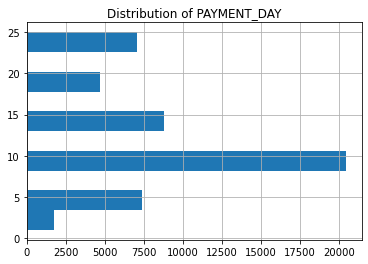

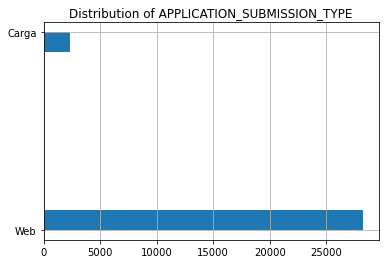

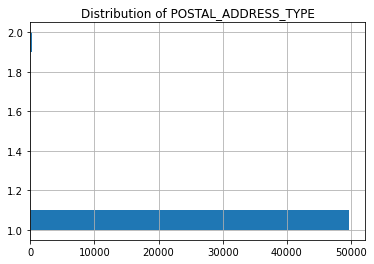

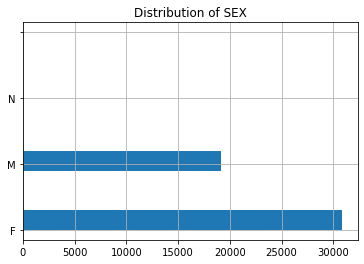

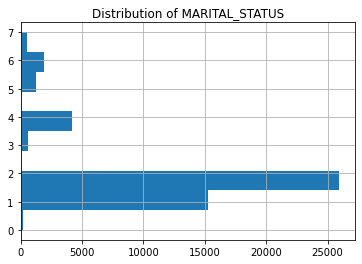

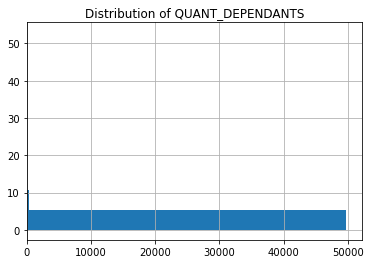

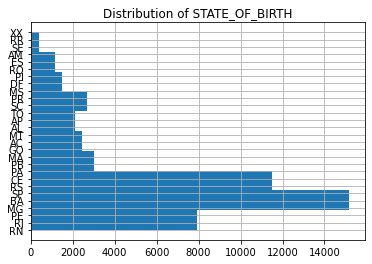

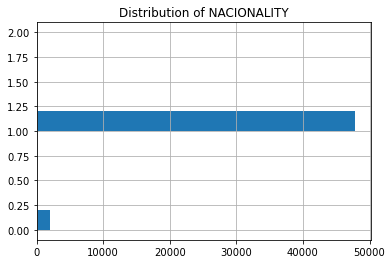

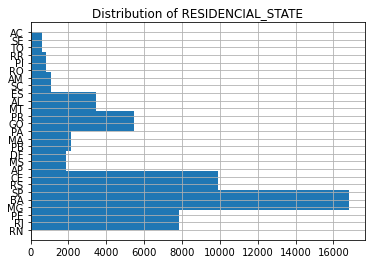

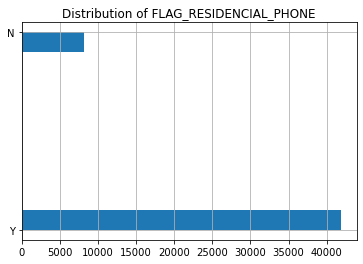

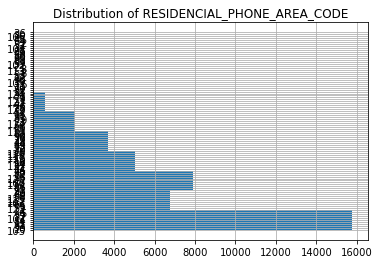

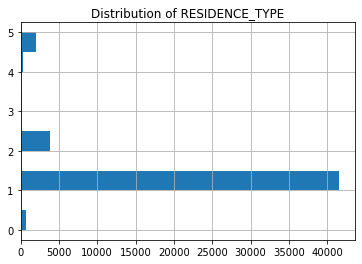

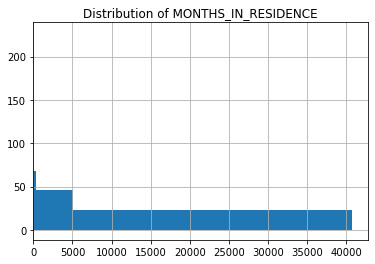

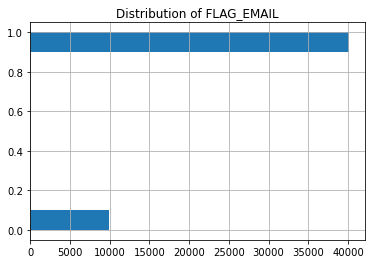

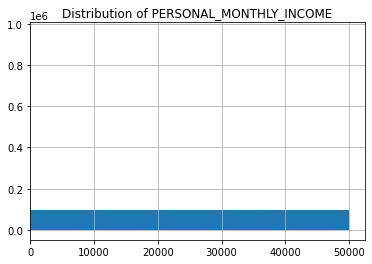

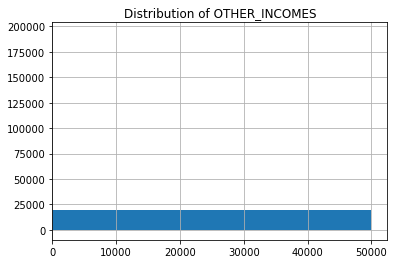

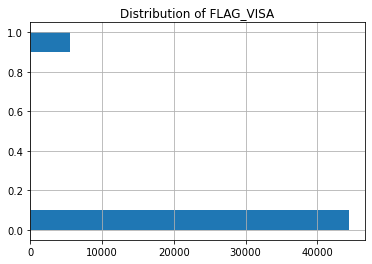

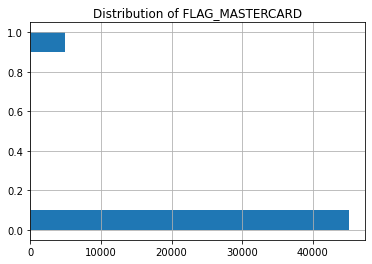

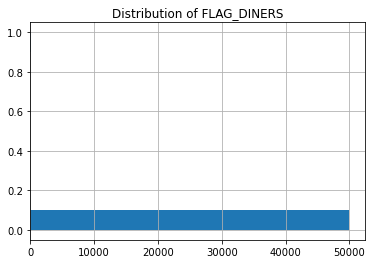

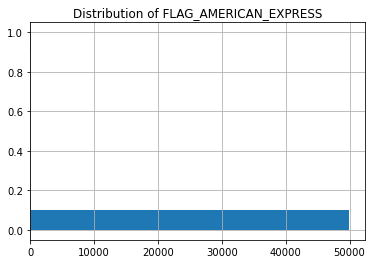

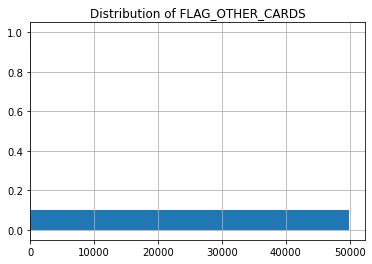

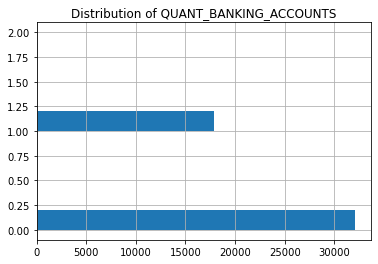

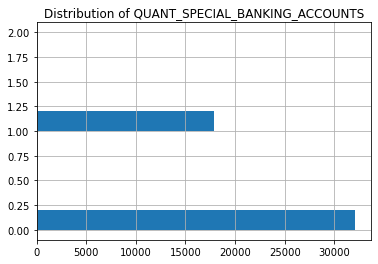

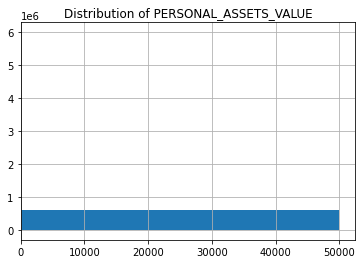

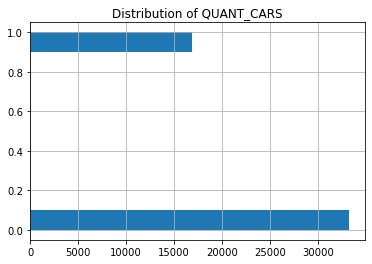

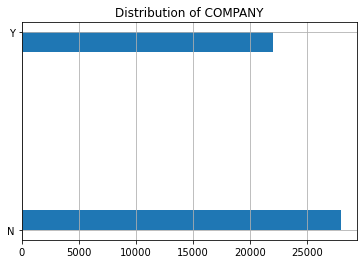

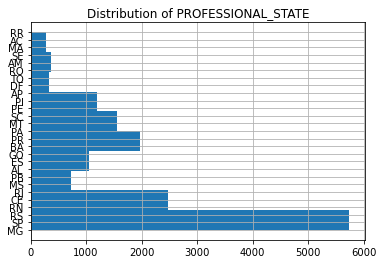

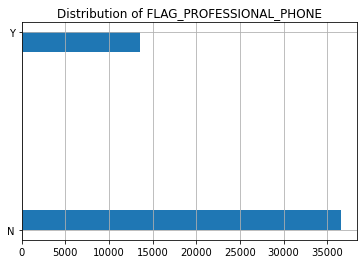

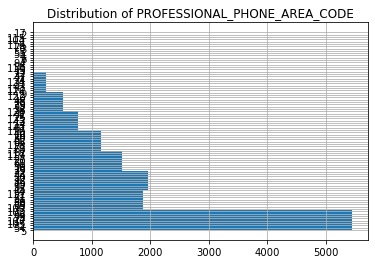

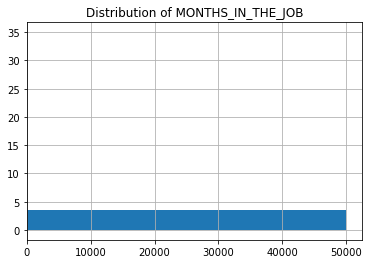

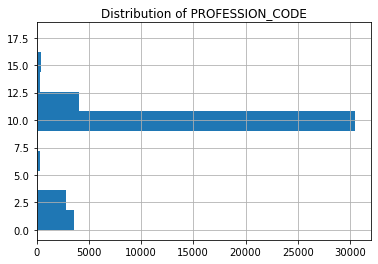

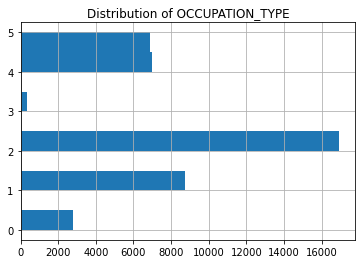

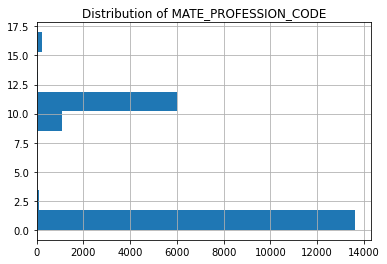

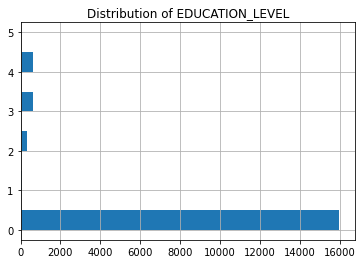

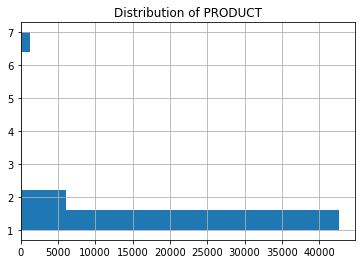

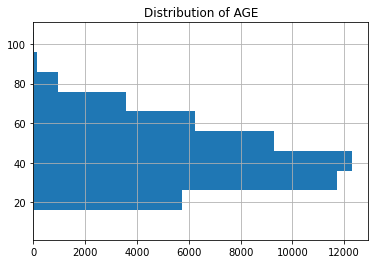

In [37]:
for col in X:
    fig, ax = plt.subplots()
    X[col].hist(ax=ax, orientation='horizontal')
    ax.set(title=f"Distribution of {col}")
    plt.show()

### Выводы 

Много мусорных фичей, которые выкинул, много категориальных фичей. Те, что остались, еще нужно обрабатывать - ограничивать и т.д. Короче, неприятный датасет на первый взгляд :)